# Model explainability for ML Models

# Table of contents

- [Introduction](#Introduction)
- [What is SHAP](#SHAP)
- [Prepare Data](#prepare)
- [Load a Trained ML model](#LoadModel)
- [Local Prediction Interpretation](#Local)
- [Global Interpretation](#Global)

# Introduction 
<a id='Introduction'></a> 

Machine learning is growing at a fast pace. Researchers are coming up with new models and architectures that are taking the predictive power of these models to new heights everyday. Amidst this growing enthusiasm about the improving model performance, there is certain growing hesitancy among the users. This hesitancy is due to the "black box" nature of a lot of these models. A lack of transparency is definitely seen and the users are even now ready to sacrifice a bit of model performance in favour of using a model which is more "explainable". Tree based models have always been explainable due to their inherent nature. 

Keep in mind the growing uset need for explainability, `arcgis.learn` has now added explainability feature to all of its models that work with tabular data. This includes all the MLModels and the fully conneccted networks. `arcgis.learn` is now integrated with the model explainability that [SHAP](https://github.com/slundberg/shap) offers. 

# What is SHAP? 
<a id='SHAP'></a> 

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. More details about SHAP and its implementation can be found here. https://github.com/slundberg/shap

# Prepare Data
<a id='prepare'></a> 

In this guide, we will use a pretrained model to get the predictions of energy generation for Solar Photovoltaic power plants using weather variables. We will then see, how using model explainability we can get the explanations for individual predictions. Finally, we will also see global model interpretibility. To get more details of the use case and how to train such a model please refer https://developers.arcgis.com/python/sample-notebooks/solar-energy-prediction-using-weather-variables/

In [1]:
import shap
import arcgis
from arcgis.gis import GIS
from arcgis.learn import FullyConnectedNetwork, MLModel, prepare_tabulardata
from sklearn.preprocessing import MinMaxScaler,RobustScaler
import pandas as pd

In [2]:
gis = GIS('https://geosaurus.maps.arcgis.com/', <<Your GIS profile User>>, <<Your GIS profile pwd>>)

In [3]:
calgary_no_southland_solar = gis.content.search('calgary_no_southland_solar owner:api_data_owner', 'feature layer')[0]
calgary_no_southland_solar
calgary_no_southland_solar_layer = calgary_no_southland_solar.layers[0]
m1 = gis.map('calgary', zoomlevel=10)
m1.add_layer(calgary_no_southland_solar_layer)
m1
calgary_no_southland_solar_layer_sdf = calgary_no_southland_solar_layer.query().sdf
calgary_no_southland_solar_layer_sdf=calgary_no_southland_solar_layer_sdf[['FID','date','ID','solar_plan','altitude_m',
                                                                           'latitude','longitude','wind_speed','dayl__s_',
                                                                           'prcp__mm_d','srad__W_m_','swe__kg_m_', 'tmax__deg',
                                                                           'tmin__deg','vp__Pa_','kWh_filled','capacity_f',
                                                                           'SHAPE']]
X = ['altitude_m', 'wind_speed', 'dayl__s_', 'prcp__mm_d','srad__W_m_','swe__kg_m_','tmax__deg','tmin__deg','vp__Pa_']
preprocessors =  [('altitude_m', 'wind_speed', 'dayl__s_', 'prcp__mm_d','srad__W_m_','swe__kg_m_','tmax__deg',
                   'tmin__deg','vp__Pa_', RobustScaler())]

In [4]:
data = prepare_tabulardata(calgary_no_southland_solar_layer,
                           'capacity_f',
                           explanatory_variables=X,                           
                           preprocessors=preprocessors)

# Load a Trained ML Model 
<a id='LoadModel'></a> 

Here we load a trained model which can predict the efficiency of the solar panels based on attributes like length of the day, weather , temperature etc.

In [15]:
model=MLModel.from_model('C:/Users/Karthik/Desktop/Base/MLModel/ML_Model_RF1/ML_Model_RF1.emd',data)

In [ ]:
valid=data._dataframe.iloc[data._validation_indexes,:]
train=data._dataframe.iloc[data._training_indexes,:]

# Local Prediction interpretation
<a id='Local'></a>

Now we make a prediction on a sample row. The predict method in `arcgis.learn` MLModel and Fully connected network has been modified to accept two new parameters 'explain' and 'explain_index'. 

- The paramter explain is boolean and setting this parameter to True allows the user to get the explanation of the prediction. 

- The paramter explain_index is an int and it is the index of the row of the dataframe for which the user would like to get the explanation for. It is only possible to get explanation for one row/index/sample at a time. 

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


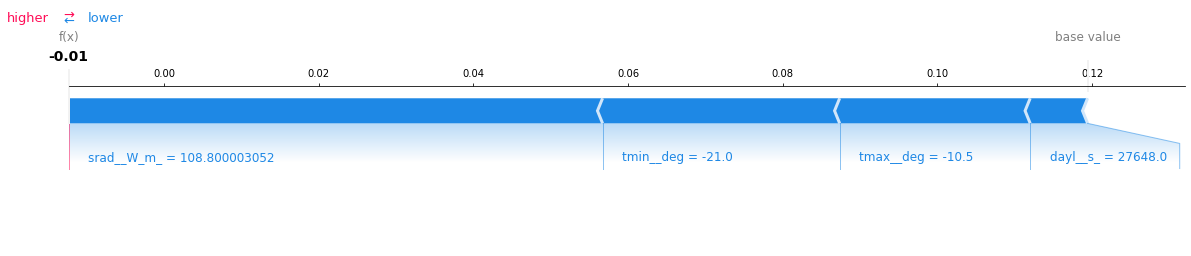

,altitude_m,wind_speed,dayl__s_,prcp__mm_d,srad__W_m_,swe__kg_m_,tmax__deg,tmin__deg,vp__Pa_,prediction_results
0,1095,7.204670,27648.000000,1,108.800003,12,-10.5,-21.0,120,-0.012350
1,1095,3.385235,27648.000000,1,115.199997,12,-18.0,-29.5,40,-0.023367
2,1095,5.076316,27648.000000,0,118.400002,12,-20.0,-32.0,40,-0.033506
3,1095,5.617623,27648.000000,0,96.000000,12,-18.0,-26.5,80,-0.032795
4,1095,2.561512,27648.000000,0,118.400002,12,-17.0,-28.5,40,-0.019064
5,1095,3.362019,27993.599609,2,67.199997,16,-21.5,-27.0,80,-0.043717
6,1095,4.025039,27993.599609,5,48.000000,20,-25.5,-30.5,40,-0.060310
7,1095,4.275431,27993.599609,0,112.000000,20,-24.5,-34.5,40,-0.047935
8,1095,8.036874,27993.599609,0,150.399994,0,-5.0,-30.5,40,-0.000990
9,1095,9.595293,27993.599609,0,112.000000,0,0.0,-11.0,280,0.015096


In [16]:
out=model.predict(model._data._dataframe[X],prediction_type='dataframe',explain=True,explain_index=0 )
out.head(10)

Running the predictions with explain set to true will generate a plot which is shown above, along with the predictions for all the samples passed into the predict function. Note, that the prediction explanation is generated only for the first observation (With row 0) since 0 was passed as the value for the parameter explai_index

The plot says that the mean average value of the entire dataset (denoted as base value in the plot) is 0.12 and the prediction for this specific observation is -0.01.
Apart from this plot also says that the parameter srad_W_m has had the greatest influence on the model in getting the prediction of this specific record. This is represented by the length of the block srad_W_m_. 
All the parameters in Blue are making the model move away towards the left from the base prediction and the parameters in Red (In this case - None) are influencing the model positively. 

For more details , refer to https://github.com/slundberg/shap

# Global Interpretation
<a id='Global'></a>

We can now also visualize the global interpretation (Similar to feature importance in sklearn). Unlike sklearn this plot can be generated for non tree models of sklearn as well.This plot tells the user the impact that each feature in the dataset has on the model as a whole. We can infer from the plot that the feature srad_W_m_ has the highest impact on the model decision making and the feature altitude_m has the least impact.

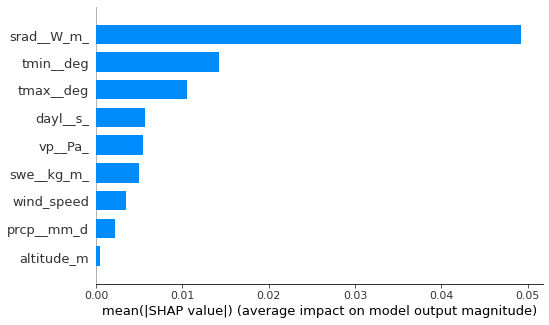

In [10]:
model_lin.feature_importances_